In [1]:
import numpy as np
import pandas as pd
import random as r
import math
import os
from datetime import timedelta
import statistics as stats 

import matplotlib.pyplot as plot
import networkx as nx
import seaborn as sns
import matplotlib.ticker as mtick

from pyomo.environ import *
from pyomo.opt import SolverFactory
from gurobipy import GRB

In [2]:
K_set = 1
T_set = 10
I_set = 4

In [3]:
dem_dictionary_k = {1: [40000, 80000, 50000]
}

#define supply attributes
#capacity
cap_dictionary_supplier_SKU = {1: [9000,11000,10000], #min, max, likely, a,b,c
                     2: [10000,20000,15000], 
                     3: [13000,20000,17000],
                     4: [40000,100000,60000]}


#lead-time
lead_time_dictionary_supplier_SKU = {1: [3,5,4], #min, max, likely, a,b,c
                     2: [1,3,2], 
                     3: [3,5,4],
                     4: [0,2,0]}

#dynamic adj
dynamic_adj_dem = [0.5, 0.55, 0.6, 1, 1.1, 1.5, 1.6, 1.2, 1.1, 0.85]
dynamic_adj_supply = np.zeros(T_set)
for t in range(1, T_set+1):
    if dynamic_adj_dem[t-1] < 1:
        dynamic_adj_supply[t-1] = 1+(1-dynamic_adj_dem[t-1])
    else:
        dynamic_adj_supply[t-1] = 2-dynamic_adj_dem[t-1]

budget = 700000
warehouse_cap_level = 1.5 #time intervals of expected supply needed that can be stored
reliability_level = .75
dynamic = False

#supplier-SKU names
names_supplier_SKU = ['Supplier 1 - SKU: N95-MG', 'Supplier 1 - SKU: N95-N', 
 'Supplier 2 - SKU: SUR-MG', 'Supplier 2 - SKU: SUR-N']

In [4]:
def triangular_dist_demand(a,b,c,prob):
    if prob <= (c-a)/(b-a):
        return(a+((((prob)*(b-a)*(c-a)))**(1/2)))
    else:
        return(b-(((1-prob)*(b-a)*(b-c))**(1/2)))

In [5]:
def triangular_dist_supply(a,b,c,prob):
    if 1-prob <= (c-a)/(b-a):
        return(a+((((1-prob)*(b-a)*(c-a)))**(1/2)))
    else:
        return(b-(((prob)*(b-a)*(b-c))**(1/2)))

In [6]:
def lead_time_dist(a,b,c):
    lead_time_dist_array = np.zeros(T_set+1)
    cum_prob = 0
    t = 0
    
    while t < b+1:
        if t+1 <= a:
            t = t+1 
        elif (a < t+1 & t+1 <= c):
            cum_prob_temp = ((t+1-a)**2)/((b+1-a)*(c-a))
            prob = cum_prob_temp - cum_prob
            lead_time_dist_array[t] = prob
            cum_prob = cum_prob_temp
            t = t+1
        elif c < t+1 & t+1 <= b+1:
            cum_prob_temp = 1-((b+1-(t+1))**2)/((b+1-a)*(b+1-c))
            prob = cum_prob_temp - cum_prob
            lead_time_dist_array[t] = prob
            cum_prob = cum_prob_temp
            t = t+1
    
    return(lead_time_dist_array)

In [7]:
k = 1

#define parameters

###health care commodity metric parameters####
#rank
r_k_dict = {
    1 : 1
}

#quality 
q_k_i_dict = {
    tuple([1,1]) : 1.3,
    tuple([1,2]): 1.2,
    tuple([1,3]): 1.2,
    tuple([1,4]): 1.1
}


####Supply Parameters#####

#lead time (supplier 3 has the lowest lead time)
f_k_i_tDiff_dict = {}
for i in range(1,I_set+1):
    lead_time_dist_array = lead_time_dist(lead_time_dictionary_supplier_SKU.get(i)[0],
                                         lead_time_dictionary_supplier_SKU.get(i)[1],
                                         lead_time_dictionary_supplier_SKU.get(i)[2])
    for t in range(0,T_set+1):
                f_k_i_tDiff_dict[tuple([k,i,t])] = lead_time_dist_array[t]


#incoming orders
o_k_i_t_dict = {}

for k in range(1,K_set+1):
    for i in range(1,I_set+1):
        for t in range(1,T_set+1):
            if t <= 2:
                o_k_i_t_dict[tuple([k,i,t])] = 0 #20000/4 #5000
            else:
                o_k_i_t_dict[tuple([k,i,t])] = 0



#lead time (supplier 1 has the higest capacity)
CAP_k_i_t_dict = {}

for i in range(1,I_set+1):
    cap_temp = triangular_dist_supply(cap_dictionary_supplier_SKU.get(i)[0],
                                      cap_dictionary_supplier_SKU.get(i)[1],
                                      cap_dictionary_supplier_SKU.get(i)[2],
                                      reliability_level)
    if (dynamic == True):
        for t in range(1,T_set+1):
            cap_temp_2 = cap_temp*dynamic_adj_supply[t-1]
            CAP_k_i_t_dict[tuple([k,i,t])] = cap_temp_2
    else:
        for t in range(1,T_set+1):
            CAP_k_i_t_dict[tuple([k,i,t])] = cap_temp

####Demand Parameters####
n_k_init_dict = {
    1 : 0
}


#demand RV
D_k_t_dict = {}
demand_temp = triangular_dist_demand(dem_dictionary_k.get(k)[0],
                                     dem_dictionary_k.get(k)[1],
                                     dem_dictionary_k.get(k)[2],
                                     reliability_level)

if (dynamic == True):
    for t in range(1,T_set+1):
        demand_temp_2 =demand_temp*dynamic_adj_dem[t-1]
        D_k_t_dict[tuple([k,t])] = demand_temp_2
else:
    for t in range(1,T_set+1):
        D_k_t_dict[tuple([k,t])] = demand_temp


#starting inventory
z_k_i_init_dict = {
    tuple([1,1]) : 80000/4,
    tuple([1,2]) : 80000/4,
    tuple([1,3]) : 80000/4,
    tuple([1,4]) : 80000/4
}

#size
s_k_dict = {
    1 : 1
}

#warehouse capacity
h = 80000*warehouse_cap_level 

#cost (supplier 2 has the lowest cost)
c_k_i_dict = {
    tuple([1,1]) : 2,
    tuple([1,2]) : 1.5,
    tuple([1,3]) : 1,
    tuple([1,4]) : .8
}

b = budget

100

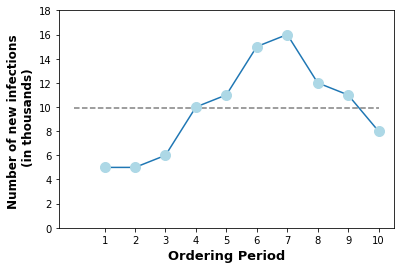

In [35]:
proj_infections = [int(d * 10) for d in dynamic_adj_dem]
import statistics
mean_infections = statistics.mean(proj_infections)
plot.plot(np.arange(1,11,1),proj_infections)
plot.plot(np.arange(1,11,1), proj_infections, 'o', markersize = 10, color = 'lightblue')
plot.xlabel('Ordering Period', fontsize = 13, fontweight = 'bold')
plot.xticks(np.arange(1, 12, step=1))
plot.ylabel('Number of new infections \n (in thousands)', fontsize = 12, fontweight = 'bold')
plot.ylim(0,18)
plot.hlines(mean_infections, xmin = 0, xmax = 10, color = 'gray', linestyles = 'dashed')

In [9]:
#lead time (supplier 3 has the lowest lead time)
f_k_i_tDiff_dict = {}
for i in range(1,I_set+1):
    lead_time_dist_array = lead_time_dist(lead_time_dictionary_supplier_SKU.get(i)[0],
                                         lead_time_dictionary_supplier_SKU.get(i)[1],
                                         lead_time_dictionary_supplier_SKU.get(i)[2])
    for t in range(0,T_set+1):
                f_k_i_tDiff_dict[tuple([k,i,t])] = lead_time_dist_array[t]

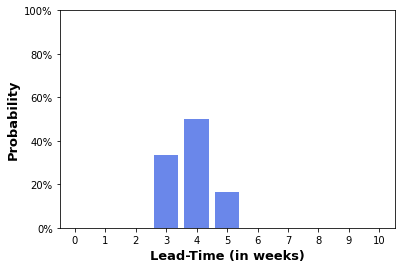

In [42]:
i = 1
temp = np.zeros(T_set+1)
for t in range(0,T_set+1):
    temp[t] = (f_k_i_tDiff_dict.get(tuple([1,i,t]))*100)

fig, ax = plot.subplots(figsize=(6,4))
temp2 = pd.DataFrame()
temp2['Lead-Time Probability'] = temp
temp2['Ordering Period'] = np.arange(0,11,1)

sns.barplot(x="Ordering Period", y="Lead-Time Probability", data=temp2, color = '#557BFF')
ax.set_xlabel('Lead-Time (in weeks)', fontsize = 13, fontweight = 'bold')
ax.set_ylabel('Probability', fontsize = 13, fontweight = 'bold')
ax.set(ylim=(0, 100))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

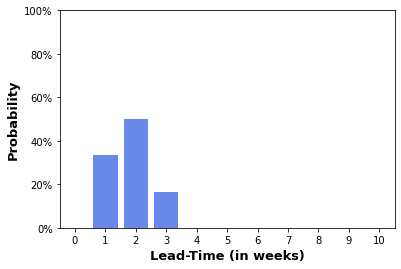

In [46]:
i = 2
temp = np.zeros(T_set+1)
for t in range(0,T_set+1):
    temp[t] = (f_k_i_tDiff_dict.get(tuple([1,i,t]))*100)

fig, ax = plot.subplots(figsize=(6,4))
temp2 = pd.DataFrame()
temp2['Lead-Time Probability'] = temp
temp2['Ordering Period'] = np.arange(0,11,1)

sns.barplot(x="Ordering Period", y="Lead-Time Probability", data=temp2, color = '#557BFF')
ax.set_xlabel('Lead-Time (in weeks)', fontsize = 13, fontweight = 'bold')
ax.set_ylabel('Probability', fontsize = 13, fontweight = 'bold')
ax.set(ylim=(0, 100))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

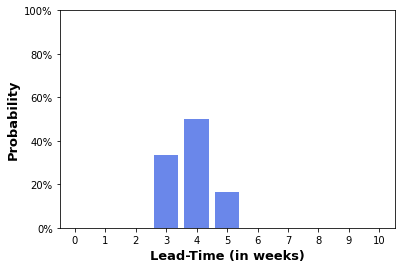

In [47]:
i = 3
temp = np.zeros(T_set+1)
for t in range(0,T_set+1):
    temp[t] = (f_k_i_tDiff_dict.get(tuple([1,i,t]))*100)

fig, ax = plot.subplots(figsize=(6,4))
temp2 = pd.DataFrame()
temp2['Lead-Time Probability'] = temp
temp2['Ordering Period'] = np.arange(0,11,1)

sns.barplot(x="Ordering Period", y="Lead-Time Probability", data=temp2, color = '#557BFF')
ax.set_xlabel('Lead-Time (in weeks)', fontsize = 13, fontweight = 'bold')
ax.set_ylabel('Probability', fontsize = 13, fontweight = 'bold')
ax.set(ylim=(0, 100))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

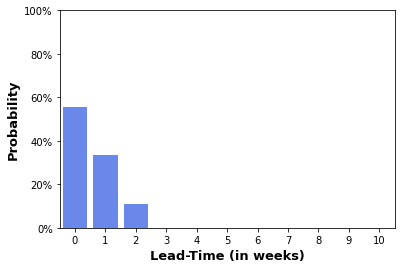

In [48]:
i = 4
temp = np.zeros(T_set+1)
for t in range(0,T_set+1):
    temp[t] = (f_k_i_tDiff_dict.get(tuple([1,i,t]))*100)

fig, ax = plot.subplots(figsize=(6,4))
temp2 = pd.DataFrame()
temp2['Lead-Time Probability'] = temp
temp2['Ordering Period'] = np.arange(0,11,1)

sns.barplot(x="Ordering Period", y="Lead-Time Probability", data=temp2, color = '#557BFF')
ax.set_xlabel('Lead-Time (in weeks)', fontsize = 13, fontweight = 'bold')
ax.set_ylabel('Probability', fontsize = 13, fontweight = 'bold')
ax.set(ylim=(0, 100))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

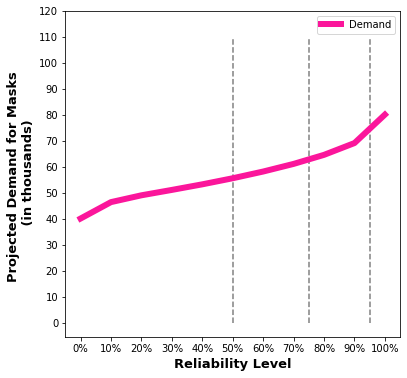

In [50]:
prob = np.arange(0,1.1,.1)
demanddist = np.zeros(len(prob))
counter = 0

prob_100 = [int(p * 100) for p in prob]

for p in prob:
    dem = dem_dictionary_k.get(1)
    demanddist[counter] = triangular_dist_demand(dem[0],dem[1],dem[2],p)
    counter = counter +1

fig, ax2 = plot.subplots(figsize=(6,6))
demanddist_1000 = [d/1000 for d in demanddist]

ax2.xaxis.set_major_formatter(mtick.PercentFormatter())

plot.plot(prob_100, demanddist_1000, 
          label='Incoming Demand', #\n additional demand \nplus unfulfilled demand\nfrom the day before',
          linewidth=6,
          color = "#fb169b")

marker_probs = [.5, .75, .95]
marker_probs_100 = [int(p * 100) for p in marker_probs]

plot.vlines(marker_probs_100, ymin = 0, ymax = 110, color = 'gray', linestyles = 'dashed')
ax2.set_yticks(np.arange(0,130,10))
ax2.set_xticks(np.arange(0,110,10))
ax2.set_ylabel('Projected Demand for Masks \n (in thousands)', fontsize = 13, fontweight = 'bold')
ax2.set_xlabel('Reliability Level', fontsize = 13, fontweight = 'bold')
ax2.legend(['Demand'],
          loc = 'upper right')

In [15]:
supplydist_1= np.zeros(len(prob))
supplydist_2= np.zeros(len(prob))
supplydist_3= np.zeros(len(prob))
supplydist_4= np.zeros(len(prob))

supplydist_1_markers= np.zeros(len(marker_probs))
supplydist_2_markers= np.zeros(len(marker_probs))
supplydist_3_markers= np.zeros(len(marker_probs))
supplydist_4_markers= np.zeros(len(marker_probs))

for i in range(1,I_set+1):
    cap = cap_dictionary_supplier_SKU.get(i)
    counter = 0
    for p in prob:
        if i == 1:
            global supplydist_1
            supplydist_1[counter] = triangular_dist_supply(cap[0], cap[1], cap[2], p)
            counter = counter + 1
        elif i == 2:
            global supplydist_2
            supplydist_2[counter] = triangular_dist_supply(cap[0], cap[1], cap[2], p)
            counter = counter + 1
        elif i == 3:
            global supplydist_3
            supplydist_3[counter] = triangular_dist_supply(cap[0], cap[1], cap[2], p)
            counter = counter + 1
        else:
            global supplydist_4
            supplydist_4[counter] = triangular_dist_supply(cap[0], cap[1], cap[2], p)
            counter = counter + 1
            
            
for i in range(1,I_set+1):
    cap = cap_dictionary_supplier_SKU.get(i)
    counter = 0
    for p in marker_probs:
        if i == 1:
            supplydist_1_markers[counter] = triangular_dist_supply(cap[0], cap[1], cap[2], p)
            counter = counter + 1
        elif i == 2:
            supplydist_2_markers[counter] = triangular_dist_supply(cap[0], cap[1], cap[2], p)
            counter = counter + 1
        elif i == 3:
            supplydist_3_markers[counter] = triangular_dist_supply(cap[0], cap[1], cap[2], p)
            counter = counter + 1
        else:
            supplydist_4_markers[counter] = triangular_dist_supply(cap[0], cap[1], cap[2], p)
            counter = counter + 1

Text(0.5, 0, 'Reliability Level')

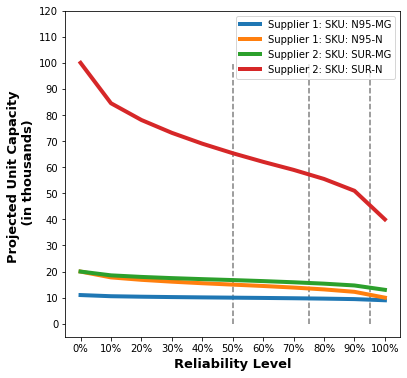

In [49]:
fig, ax3 = plot.subplots(figsize=(6,6))
supplydist_1_1000 = [s/1000 for s in supplydist_1]
supplydist_2_1000 = [s/1000 for s in supplydist_2]
supplydist_3_1000 = [s/1000 for s in supplydist_3]
supplydist_4_1000 = [s/1000 for s in supplydist_4]

supplydist_1_markers_1000 = [s/1000 for s in supplydist_1_markers]
supplydist_2_markers_1000 = [s/1000 for s in supplydist_2_markers]
supplydist_3_markers_1000 = [s/1000 for s in supplydist_3_markers]
supplydist_4_markers_1000 = [s/1000 for s in supplydist_4_markers]


ax3.xaxis.set_major_formatter(mtick.PercentFormatter())

pal = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', "808080"]
plot.vlines(marker_probs_100, ymin = 0, ymax = 100, color = 'gray', linestyles = 'dashed')
plot.plot(prob_100, supplydist_1_1000, color = pal[0], linewidth=4)
plot.plot(prob_100, supplydist_2_1000, color = pal[1], linewidth=4)
plot.plot(prob_100, supplydist_3_1000, color = pal[2], linewidth=4)
plot.plot(prob_100, supplydist_4_1000, color = pal[3], linewidth=4)


#plot.scatter(marker_probs_100[0], supplydist_1_markers_1000[0],marker='X', s = 300, color = pal[0])
#ax3.annotate(int(supplydist_1_markers_1000[0]), (marker_probs_100[0], supplydist_1_markers_1000[0]), 
#             bbox=dict(boxstyle="round", fc="0.8"), 
#             fontsize=20,  color = pal[0], ha='center',
#            arrowprops=dict(arrowstyle="->"))


#plot.scatter(marker_probs_100[0], supplydist_2_markers_1000[0],marker='o', s = 100, color = pal[1])
#plot.scatter(marker_probs_100[0], supplydist_3_markers_1000[0],marker='o', s = 100, color = pal[2])
#plot.scatter(marker_probs_100[0], supplydist_4_markers_1000[0],marker='o', s = 100, color = pal[3])

#plot.scatter(marker_probs_100[1], supplydist_1_markers_1000[1],marker='s', s = 300, color = pal[0])
#plot.scatter(marker_probs_100[1], supplydist_2_markers_1000[1],marker='s', s = 300, color = pal[1])
#plot.scatter(marker_probs_100[1], supplydist_3_markers_1000[1],marker='s', s = 300, color = pal[2])
#plot.scatter(marker_probs_100[1], supplydist_4_markers_1000[1],marker='s', s = 300, color = pal[3])

#plot.scatter(marker_probs_100[2], supplydist_1_markers_1000[2],marker='v', s = 300, color = pal[0])
#plot.scatter(marker_probs_100[2], supplydist_2_markers_1000[2],marker='v', s = 300, color = pal[1])
#plot.scatter(marker_probs_100[2], supplydist_3_markers_1000[2],marker='v', s = 300, color = pal[2])
#plot.scatter(marker_probs_100[2], supplydist_4_markers_1000[2],marker='v', s = 300, color = pal[3])

#plot.vlines(75, ymin = 0, ymax = 100)
#plot.vlines(75, ymin = 0, ymax = 100)

ax3.legend(['Supplier 1: SKU: N95-MG', 'Supplier 1: SKU: N95-N', 'Supplier 2: SKU: SUR-MG', 'Supplier 2: SKU: SUR-N'],
          loc = 'upper right')
ax3.set_yticks(np.arange(0,130,10))
ax3.set_xticks(np.arange(0,110,10))
ax3.set_ylabel('Projected Unit Capacity \n (in thousands)', fontsize = 13, fontweight = 'bold')
ax3.set_xlabel('Reliability Level', fontsize = 13, fontweight = 'bold')

In [17]:
dynamic = True
reliability_level = .5

#lead time (supplier 1 has the higest capacity)
CAP_k_i_t_dict = {}

for i in range(1,I_set+1):
    cap_temp = triangular_dist_supply(cap_dictionary_supplier_SKU.get(i)[0],
                                      cap_dictionary_supplier_SKU.get(i)[1],
                                      cap_dictionary_supplier_SKU.get(i)[2],
                                      reliability_level)
    if (dynamic == True):
        for t in range(1,T_set+1):
            cap_temp_2 = cap_temp*dynamic_adj_supply[t-1]
            CAP_k_i_t_dict[tuple([k,i,t])] = cap_temp_2
    else:
        for t in range(1,T_set+1):
            CAP_k_i_t_dict[tuple([k,i,t])] = cap_temp
            
dyn_cap_50_df = pd.DataFrame(CAP_k_i_t_dict.items(), columns=['sets', 'Supplier-SKU Unit Capacity'])
dyn_cap_50_df.loc[:,'supplier_sku']=dyn_cap_50_df.sets.map(lambda x:x[1])
dyn_cap_50_df.loc[:,'Ordering Period']=dyn_cap_50_df.sets.map(lambda x:x[2])

In [18]:
dynamic = True
reliability_level = .75

#lead time (supplier 1 has the higest capacity)
CAP_k_i_t_dict = {}

for i in range(1,I_set+1):
    cap_temp = triangular_dist_supply(cap_dictionary_supplier_SKU.get(i)[0],
                                      cap_dictionary_supplier_SKU.get(i)[1],
                                      cap_dictionary_supplier_SKU.get(i)[2],
                                      reliability_level)
    if (dynamic == True):
        for t in range(1,T_set+1):
            cap_temp_2 = cap_temp*dynamic_adj_supply[t-1]
            CAP_k_i_t_dict[tuple([k,i,t])] = cap_temp_2
    else:
        for t in range(1,T_set+1):
            CAP_k_i_t_dict[tuple([k,i,t])] = cap_temp
            
dyn_cap_75_df = pd.DataFrame(CAP_k_i_t_dict.items(), columns=['sets', 'Supplier-SKU Unit Capacity'])
dyn_cap_75_df.loc[:,'supplier_sku']=dyn_cap_50_df.sets.map(lambda x:x[1])
dyn_cap_75_df.loc[:,'Ordering Period']=dyn_cap_50_df.sets.map(lambda x:x[2])

In [19]:
dynamic = True
reliability_level = .95

#lead time (supplier 1 has the higest capacity)
CAP_k_i_t_dict = {}

for i in range(1,I_set+1):
    cap_temp = triangular_dist_supply(cap_dictionary_supplier_SKU.get(i)[0],
                                      cap_dictionary_supplier_SKU.get(i)[1],
                                      cap_dictionary_supplier_SKU.get(i)[2],
                                      reliability_level)
    if (dynamic == True):
        for t in range(1,T_set+1):
            cap_temp_2 = cap_temp*dynamic_adj_supply[t-1]
            CAP_k_i_t_dict[tuple([k,i,t])] = cap_temp_2
    else:
        for t in range(1,T_set+1):
            CAP_k_i_t_dict[tuple([k,i,t])] = cap_temp
            
dyn_cap_95_df = pd.DataFrame(CAP_k_i_t_dict.items(), columns=['sets', 'Supplier-SKU Unit Capacity'])
dyn_cap_95_df.loc[:,'supplier_sku']=dyn_cap_50_df.sets.map(lambda x:x[1])
dyn_cap_95_df.loc[:,'Ordering Period']=dyn_cap_50_df.sets.map(lambda x:x[2])

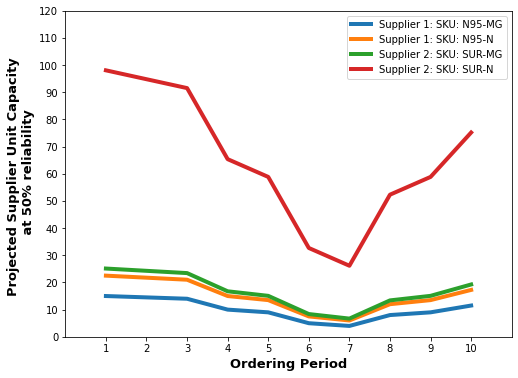

In [20]:
fig, ax50 = plot.subplots(figsize=(8,6))

dyn_cap_50_df['1000cap'] = dyn_cap_50_df['Supplier-SKU Unit Capacity']/1000

plot.plot(dyn_cap_50_df[dyn_cap_50_df['supplier_sku'] == 1]['Ordering Period'], 
          dyn_cap_50_df[dyn_cap_50_df['supplier_sku'] == 1]['1000cap'], 
          color = pal[0], linewidth=4)
plot.plot(dyn_cap_50_df[dyn_cap_50_df['supplier_sku'] == 2]['Ordering Period'],
          dyn_cap_50_df[dyn_cap_50_df['supplier_sku'] == 2]['1000cap'], 
          color = pal[1], linewidth=4)
plot.plot(dyn_cap_50_df[dyn_cap_50_df['supplier_sku'] == 3]['Ordering Period'],
          dyn_cap_50_df[dyn_cap_50_df['supplier_sku'] == 3]['1000cap'], 
          color = pal[2], linewidth=4)
plot.plot(dyn_cap_50_df[dyn_cap_50_df['supplier_sku'] == 4]['Ordering Period'], 
          dyn_cap_50_df[dyn_cap_50_df['supplier_sku'] == 4]['1000cap'], 
          color = pal[3], linewidth=4)

ax50.legend(['Supplier 1: SKU: N95-MG', 
             'Supplier 1: SKU: N95-N', 
             'Supplier 2: SKU: SUR-MG', 
             'Supplier 2: SKU: SUR-N'])

ax50.set_xlabel('Ordering Period', fontsize = 13, fontweight = 'bold')
ax50.set_ylabel('Projected Supplier Unit Capacity \n at 50% reliability', fontsize = 13, fontweight = 'bold')
ax50.set_xticks(np.arange(1,11,1))
ax50.set_yticks(np.arange(0,110,10))
ax50.set(ylim=(0, 100), xlim=(0, 11))
ax50.set_yticks(np.arange(0,130,10))

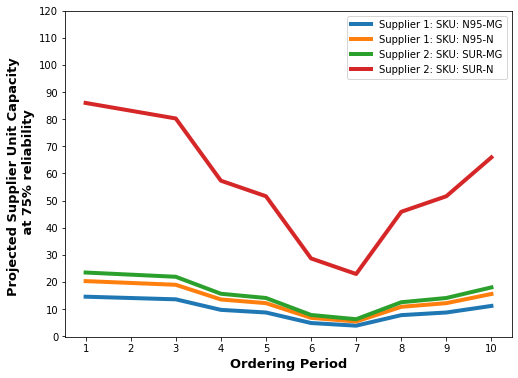

In [21]:
fig, ax75 = plot.subplots(figsize=(8,6))

dyn_cap_75_df['1000cap'] = dyn_cap_75_df['Supplier-SKU Unit Capacity']/1000

plot.plot(dyn_cap_75_df[dyn_cap_75_df['supplier_sku'] == 1]['Ordering Period'], 
          dyn_cap_75_df[dyn_cap_75_df['supplier_sku'] == 1]['1000cap'], 
          color = pal[0], linewidth=4)
plot.plot(dyn_cap_75_df[dyn_cap_75_df['supplier_sku'] == 2]['Ordering Period'],
          dyn_cap_75_df[dyn_cap_75_df['supplier_sku'] == 2]['1000cap'], 
          color = pal[1], linewidth=4)
plot.plot(dyn_cap_75_df[dyn_cap_75_df['supplier_sku'] == 3]['Ordering Period'],
          dyn_cap_75_df[dyn_cap_75_df['supplier_sku'] == 3]['1000cap'], 
          color = pal[2], linewidth=4)
plot.plot(dyn_cap_75_df[dyn_cap_75_df['supplier_sku'] == 4]['Ordering Period'], 
          dyn_cap_75_df[dyn_cap_75_df['supplier_sku'] == 4]['1000cap'], 
          color = pal[3], linewidth=4)

ax75.legend(['Supplier 1: SKU: N95-MG', 
             'Supplier 1: SKU: N95-N', 
             'Supplier 2: SKU: SUR-MG', 
             'Supplier 2: SKU: SUR-N'])

ax75.set_xlabel('Ordering Period', fontsize = 13, fontweight = 'bold')
ax75.set_ylabel('Projected Supplier Unit Capacity \n at 75% reliability', fontsize = 13, fontweight = 'bold')
ax75.set_xticks(np.arange(1,11,1))
ax75.set_yticks(np.arange(0,130,10))

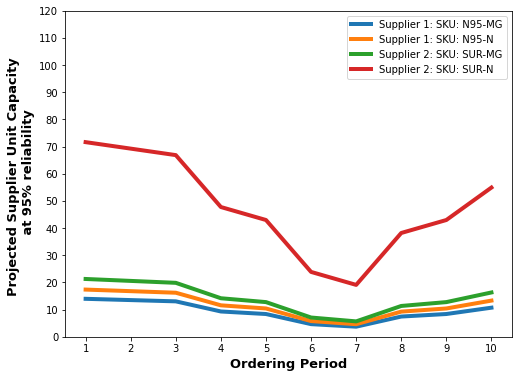

In [22]:
fig, ax95 = plot.subplots(figsize=(8,6))

dyn_cap_95_df['1000cap'] = dyn_cap_95_df['Supplier-SKU Unit Capacity']/1000

plot.plot(dyn_cap_95_df[dyn_cap_95_df['supplier_sku'] == 1]['Ordering Period'], 
          dyn_cap_95_df[dyn_cap_95_df['supplier_sku'] == 1]['1000cap'], 
          color = pal[0], linewidth=4)
plot.plot(dyn_cap_95_df[dyn_cap_95_df['supplier_sku'] == 2]['Ordering Period'],
          dyn_cap_95_df[dyn_cap_95_df['supplier_sku'] == 2]['1000cap'], 
          color = pal[1], linewidth=4)
plot.plot(dyn_cap_95_df[dyn_cap_95_df['supplier_sku'] == 3]['Ordering Period'],
          dyn_cap_95_df[dyn_cap_95_df['supplier_sku'] == 3]['1000cap'], 
          color = pal[2], linewidth=4)
plot.plot(dyn_cap_95_df[dyn_cap_95_df['supplier_sku'] == 4]['Ordering Period'], 
          dyn_cap_95_df[dyn_cap_95_df['supplier_sku'] == 4]['1000cap'], 
          color = pal[3], linewidth=4)

ax95.legend(['Supplier 1: SKU: N95-MG', 
             'Supplier 1: SKU: N95-N', 
             'Supplier 2: SKU: SUR-MG', 
             'Supplier 2: SKU: SUR-N'])

ax95.set_xlabel('Ordering Period', fontsize = 13, fontweight = 'bold')
ax95.set_ylabel('Projected Supplier Unit Capacity \n at 95% reliability', fontsize = 13, fontweight = 'bold')
ax95.set_xticks(np.arange(1,11,1))
ax95.set_yticks(np.arange(0,130,10))

In [23]:
dynamic = True
reliability_level = .5

D_k_t_dict = {}
demand_temp = triangular_dist_demand(dem_dictionary_k.get(k)[0],
                                     dem_dictionary_k.get(k)[1],
                                     dem_dictionary_k.get(k)[2],
                                     reliability_level)
if (dynamic == True):
    for t in range(1,T_set+1):
        demand_temp_2 =demand_temp*dynamic_adj_dem[t-1]
        D_k_t_dict[tuple([k,t])] = demand_temp_2
else:
    for t in range(1,T_set+1):
        D_k_t_dict[tuple([k,t])] = demand_temp
        
dyn_dem_50_df = pd.DataFrame(D_k_t_dict.items(), columns=['sets', 'Demand'])
dyn_dem_50_df.loc[:,'Ordering Period']=dyn_dem_50_df.sets.map(lambda x:x[1])

In [24]:
dynamic = True
reliability_level = .75

D_k_t_dict = {}
demand_temp = triangular_dist_demand(dem_dictionary_k.get(k)[0],
                                     dem_dictionary_k.get(k)[1],
                                     dem_dictionary_k.get(k)[2],
                                     reliability_level)
if (dynamic == True):
    for t in range(1,T_set+1):
        demand_temp_2 =demand_temp*dynamic_adj_dem[t-1]
        D_k_t_dict[tuple([k,t])] = demand_temp_2
else:
    for t in range(1,T_set+1):
        D_k_t_dict[tuple([k,t])] = demand_temp
        
dyn_dem_75_df = pd.DataFrame(D_k_t_dict.items(), columns=['sets', 'Demand'])
dyn_dem_75_df.loc[:,'Ordering Period']=dyn_dem_75_df.sets.map(lambda x:x[1])

In [25]:
dynamic = True
reliability_level = .95

D_k_t_dict = {}
demand_temp = triangular_dist_demand(dem_dictionary_k.get(k)[0],
                                     dem_dictionary_k.get(k)[1],
                                     dem_dictionary_k.get(k)[2],
                                     reliability_level)
if (dynamic == True):
    for t in range(1,T_set+1):
        demand_temp_2 =demand_temp*dynamic_adj_dem[t-1]
        D_k_t_dict[tuple([k,t])] = demand_temp_2
else:
    for t in range(1,T_set+1):
        D_k_t_dict[tuple([k,t])] = demand_temp
        
dyn_dem_95_df = pd.DataFrame(D_k_t_dict.items(), columns=['sets', 'Demand'])
dyn_dem_95_df.loc[:,'Ordering Period']=dyn_dem_95_df.sets.map(lambda x:x[1])

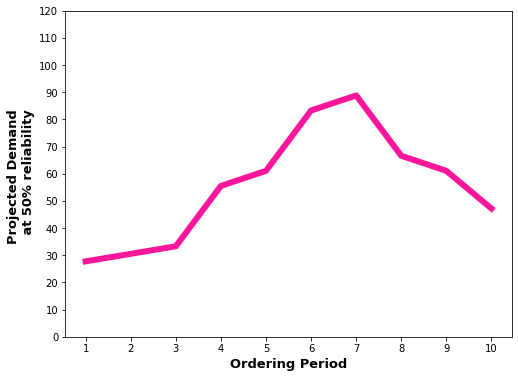

In [26]:
fig, axdemand_50 = plot.subplots(figsize=(8,6))

dyn_dem_50_df['1000dem'] = dyn_dem_50_df['Demand']/1000

plot.plot(dyn_dem_50_df['Ordering Period'], 
          dyn_dem_50_df['1000dem'], 
          linewidth=6,
          color = "#fb169b")

axdemand_50.set_xlabel('Ordering Period', fontsize = 13, fontweight = 'bold')
axdemand_50.set_ylabel('Projected Demand \n at 50% reliability', fontsize = 13, fontweight = 'bold')
axdemand_50.set_xticks(np.arange(1,11,1))
axdemand_50.set_yticks(np.arange(0,130,10))

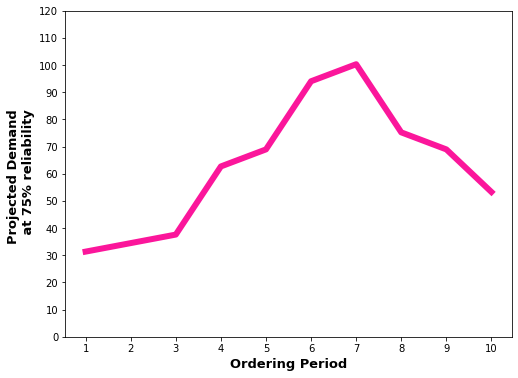

In [27]:
fig, axdemand_75 = plot.subplots(figsize=(8,6))

dyn_dem_75_df['1000dem'] = dyn_dem_75_df['Demand']/1000

plot.plot(dyn_dem_75_df['Ordering Period'], 
          dyn_dem_75_df['1000dem'], 
          linewidth=6,
          color = "#fb169b")

axdemand_75.set_xlabel('Ordering Period', fontsize = 13, fontweight = 'bold')
axdemand_75.set_ylabel('Projected Demand \n at 75% reliability', fontsize = 13, fontweight = 'bold')
axdemand_75.set_xticks(np.arange(1,11,1))
axdemand_75.set_yticks(np.arange(0,130,10))

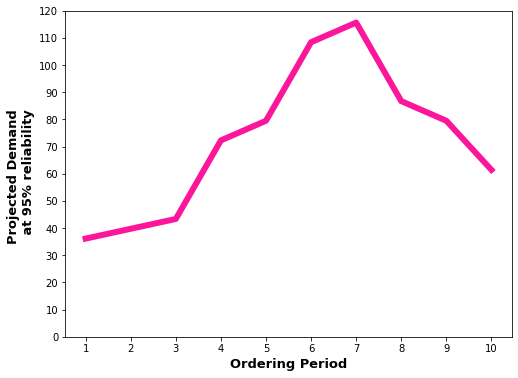

In [28]:
fig, axdemand_95 = plot.subplots(figsize=(8,6))

dyn_dem_95_df['1000dem'] = dyn_dem_95_df['Demand']/1000

plot.plot(dyn_dem_95_df['Ordering Period'], 
          dyn_dem_95_df['1000dem'], 
          linewidth=6,
          color = "#fb169b")

axdemand_95.set_xlabel('Ordering Period', fontsize = 13, fontweight = 'bold')
axdemand_95.set_ylabel('Projected Demand \n at 95% reliability', fontsize = 13, fontweight = 'bold')
axdemand_95.set_xticks(np.arange(1,11,1))
axdemand_95.set_yticks(np.arange(0,130,10))